In [1]:
from counterfactualEO import *
import joblib
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
import os
import pandas as pd
import pickle
import seaborn as sns
# from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.model_selection import KFold

# Functions

In [3]:
import cvxpy as cp
import itertools
import numpy as np
import pandas as pd
import scipy
from scipy.special import expit, logit
from sklearn.model_selection import train_test_split


def train_nuisance(train, test, A, X, R, D, Y, learner_pi, learner_mu,
                   trunc_pi=0.975):
    """Train nuisance regressions."""
    train = train.reset_index()
    test = test.reset_index()
    # pred_cols = list(itertools.chain.from_iterable([A, X, R]))
    pred_cols = [A] + X + [R]
    learner_pi.fit(train[pred_cols], train[D])
    learner_mu.fit(train.loc[train[D].eq(0), pred_cols],
                   train.loc[train[D].eq(0), Y])
    if hasattr(learner_pi, 'predict_proba'):
        pihat = pd.Series(learner_pi.predict_proba(test[pred_cols])[:, 1],
                          name='pihat').clip(upper=trunc_pi)
    else:
        pihat = pd.Series(learner_pi.predict(test[pred_cols]),
                          name='pihat').clip(upper=trunc_pi)
    if hasattr(learner_mu, 'predict_proba'):
        muhat0 = pd.Series(learner_mu.predict_proba(test[pred_cols])[:, 1],
                           name='muhat0')
    else:
        muhat0 = pd.Series(learner_mu.predict(test[pred_cols]), name='muhat0')
    phihat = pd.Series(
        (1 - test[D]) / (1 - pihat) * (test[Y] - muhat0) + muhat0,
        name='phihat')

    out = pd.concat([pihat, muhat0, phihat], axis=1)

    return out


#########################
#### Risk functions #####
#########################

def risk_coef(data, a, r, A='A', R='R', outcome='phihat'):
    """Compute the loss coefficient for a single row, for given values
    A = a, R = r.

    Using phihat as the outcome yields a doubly robust estimator.
    Using muhat0 as the outcome yields a plugin estimator.
    Using mu0 as the outcome yields (something close to) the ``true'' loss
    coefficient.
    """
    out = (((data[A] == a) & (data[R] == r)) * (1 - 2 * data[outcome])).mean()

    return out


def risk_coefs(data, A='A', R='R', outcome='phihat'):
    """Compute the loss coefficients.

    Using phihat as the outcome yields a doubly robust estimator.
    Using muhat0 as the outcome yields a plugin estimator.
    Using mu0 as the outcome yields (something close to) the ``true'' loss
    coefficients.
    """
    ar_list = [(0, 0), (0, 1), (1, 0), (1, 1)]
    coefs = [risk_coef(data, a, r, A, R, outcome) for a, r in ar_list]
    out = np.array(coefs).clip(-1, 1)

    return out


###############################
#### Error rate functions #####
###############################

# def cFPR(data, R, outcome='phihat'):
#     """Compute estimated counterfactual False Positive Rate."""
#     return (data[R]*(1 - data[outcome])).mean() / (1 - data[outcome]).mean()

# def cFPR(data, A, R, outcome):
#     """Compute estimated group-specific counterfactual False Positive Rate."""
#     return data.groupby(A).apply(_cFPR, R, outcome).values

# def cFNR(data, R, outcome='phihat'):
#     """Compute estimated counterfactual False Positive Rate."""
#     return ((1 - data[R])*data[outcome]).mean() / data[outcome].mean()

# def cFNR(data, A, R, outcome):
#     """Compute estimated group-specific counterfactual False Positive Rate."""
#     return data.groupby(A).apply(_cFNR, R, outcome).values

def cFPR(data, R, outcome='phihat'):
    """Compute estimated counterfactual False Positive Rate."""
    out = data.eval("{}*(1 - {})".format(R, outcome)).mean() / data.eval("1 - {}".format(outcome)).mean()
    return out

def cFNR(data, R, outcome='phihat'):
    """Compute estimated counterfactual False Positive Rate."""
    out = data.eval("(1 - {})*{}".format(R, outcome)).mean() / data.eval("{}".format(outcome)).mean()
    return out

def fairness_coefs(data, A='A', R='R', outcome='phihat'):
    """Get coefficients that define the fairness constraints for the estimator."""
    false_pos = data.groupby(A).apply(cFPR, R, outcome).values.clip(0, 1)
    false_neg = data.groupby(A).apply(cFNR, R, outcome).values.clip(0, 1)
    coefs_pos = np.array(
        [1 - false_pos[0], false_pos[0], false_pos[1] - 1, -false_pos[1]])
    coefs_neg = np.array(
        [-false_neg[0], false_neg[0] - 1, false_neg[1], 1 - false_neg[1]])

    return (coefs_pos, coefs_neg)


def optimize(risk_coefs, coefs_pos, coefs_neg, epsilon_pos, epsilon_neg):
    """Solve the LP."""
    theta = cp.Variable(4)
    objective = cp.Minimize(risk_coefs @ theta)
    constraints = [0 <= theta, theta <= 1,
                   coefs_pos @ theta <= epsilon_pos,
                   coefs_pos @ theta >= -epsilon_pos,
                   coefs_neg @ theta <= epsilon_neg,
                   coefs_neg @ theta >= -epsilon_neg]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver=cp.ECOS_BB)

    return theta.value  # , result


#### Full optimization ####
def fair_derived(data, A, X, R, D, Y, learner_pi, learner_mu, epsilon_pos,
                 epsilon_neg, outcome='phihat', k=2, test_size=0.50, trunc_pi=0.975,
                random_state = 42):
    """Optimization with chosen estimators for loss and fairness constraints.
    
    Args:
      k: Number of folds to use for cross-fitting.
    """
    kf = KFold(n_splits = k, shuffle = True, random_state = random_state)
    theta_arr = np.zeros((k, 4))
    i = 0
    for train_index, test_index in kf.split(data):
        nuisance_fold, opt_fold = data.iloc[train_index], data.iloc[test_index]
        # TODO: this next line is wrong. Not using the folds. Right?
        data_nuisance, data_opt = train_test_split(data, test_size=test_size)
        nuis = train_nuisance(data_nuisance, data_opt, A, X, R, D, Y, learner_pi,
                              learner_mu, trunc_pi)
        data_opt = pd.concat([data_opt.reset_index(), nuis.reset_index()], axis=1)
        obj = risk_coefs(data_opt, A=A, R=R, outcome=outcome)
        fair_pos, fair_neg = fairness_coefs(data_opt, A=A, R=R, outcome=outcome)
        theta = optimize(obj, fair_pos, fair_neg, epsilon_pos, epsilon_neg)
        theta_arr[i, :] = theta
        i += 1
        
#     out = {'theta': theta, 'risk_coefs': obj,
#            'fairness_coefs_pos': fair_pos, 'fairness_coefs_neg': fair_neg}
#     return out
    return theta_arr


def indicator_df(df, A='A', R='R'):
    """Get four-column df indicating values of A and R in each row."""
    ar_list = [(0, 0), (0, 1), (1, 0), (1, 1)]
    out_list = [((df[A] == a) & (df[R] == r)) for a, r in ar_list]
    out = pd.DataFrame(np.array(out_list).T,
                       columns = ['A0_R0', 'A0_R1', 'A1_R0', 'A1_R1'])
    return out


def ci_prob(est, sd, z, n, scale='logit'):
    """Compute a CI around a probability, either on the expit or the logit scale."""
    if (scale == 'logit') and (0 < est < 1):
        sd = sd/(est*(1 - est))
        lower = expit(logit(est) - z*sd/np.sqrt(n))
        upper = expit(logit(est) + z*sd/np.sqrt(n))
    else:
        lower = max(0, est - z * sd / np.sqrt(n))
        upper = min(est + z * sd / np.sqrt(n), 1)

    return lower, upper


def ci_prob_diff(est, sd, z, n, scale='logit'):
    """Compute a CI around a difference of probabilities, either on the expit or the logit scale."""
    if (scale == 'logit') and (-1 < est < 1):
        sd = sd*2/(1 - est**2)
        lower = 2*(expit(logit(est/2 + 1/2) - z * sd / np.sqrt(n)) - 1/2)
        upper = 2*(expit(logit(est/2 + 1/2) + z * sd / np.sqrt(n)) - 1/2)
    else:
        lower = max(-1, est - z * sd / np.sqrt(n))
        upper = min(est + z * sd / np.sqrt(n), 1)

    return lower, upper


def est_risk(theta, data, A='A', R='R', outcome='phihat', ci=0.95,
             ci_scale='logit'):
    """Compute risk and risk change estimates, with optional CIs."""
    ind_df = indicator_df(data, A, R)

    ## Risk and risk change point estimates
    # influence function
    inf_risk_pre = ind_df.dot([0, 1, 0, 1]) * (1 - 2 * data[outcome]) + data[
        outcome]
    inf_risk_post = ind_df.dot(theta) * (1 - 2 * data[outcome]) + data[outcome]
    inf_change = inf_risk_post - inf_risk_pre

    risk_est = min(max(0, inf_risk_post.mean()), 1)
    change_est = min(max(-1, inf_change.mean()), 1)
    out = {'metric': ['risk', 'risk_change'], 'value': [risk_est, change_est],
           'ci_lower': [None] * 2, 'ci_upper': [None] * 2}

    ## CIs
    if ci:
        z = scipy.stats.norm.ppf((ci + 1) / 2)
        n = data.shape[0]
        risk_sd = np.std(inf_risk_post)
        change_sd = np.std(inf_change)
        lower_risk, upper_risk = ci_prob(risk_est, risk_sd, z, n, ci_scale)
        lower_change, upper_change = ci_prob_diff(change_est, change_sd, z, n, ci_scale)

        # if (ci_scale == 'logit') and (0 < risk_est < 1):
        #     risk_sd = np.std(inf_risk_post)/(risk_est*(1 - risk_est))
        #     lower_risk = expit(logit(risk_est) - z * risk_sd / np.sqrt(n))
        #     upper_risk = expit(logit(risk_est) + z * risk_sd / np.sqrt(n))
        # else:
        #     risk_sd = np.std(inf_risk_post)
        #     lower_risk = max(0, risk_est - z * risk_sd / np.sqrt(n))
        #     upper_risk = min(risk_est + z * risk_sd / np.sqrt(n), 1)
        # if (ci_scale == 'logit') and (-1 < change_est < 1):
        #     change_sd = np.std(inf_change)*2/(1 - change_est**2)
        #     lower_change = 2*(expit(logit(change_est/2 + 1/2) - z * change_sd / np.sqrt(n))) - 1
        #     upper_change = 2*(expit(logit(change_est/2 + 1/2) + z * change_sd / np.sqrt(n))) - 1
        # else:
        #     change_sd = np.std(inf_change)
        #     lower_change = max(-1, change_est - z * change_sd / np.sqrt(n))
        #     upper_change = min(change_est + z * change_sd / np.sqrt(n), 1)

        out['ci_lower'] = [lower_risk, lower_change]
        out['ci_upper'] = [upper_risk, upper_change]

    return pd.DataFrame(out)


# def est_risk(theta, data, A='A', R='R', outcome='phihat', ci=0.95):
#     """Compute risk and risk change estimates, with optional CIs."""
#     ind_df = indicator_df(data, A, R)
#
#     ## Risk and risk change point estimates
#     # influence function
#     inf_risk_pre = ind_df.dot([0, 1, 0, 1]) * (1 - 2 * data[outcome]) + data[
#         outcome]
#     inf_risk_post = ind_df.dot(theta) * (1 - 2 * data[outcome]) + data[outcome]
#     inf_change = inf_risk_post - inf_risk_pre
#
#     risk_est = min(max(0, inf_risk_post.mean()), 1)
#     change_est = min(max(-1, inf_change.mean()), 1)
#     out = {'metric': ['risk', 'risk_change'], 'value': [risk_est, change_est],
#            'ci_lower': [None] * 2, 'ci_upper': [None] * 2}
#
#     ## CIs
#     if ci:
#         z = scipy.stats.norm.ppf((ci + 1) / 2)
#         n = data.shape[0]
#         risk_sd = np.std(inf_risk_post)
#         change_sd = np.std(inf_change)
#
#         lower_risk = max(0, risk_est - z * risk_sd / np.sqrt(n))
#         upper_risk = min(risk_est + z * risk_sd / np.sqrt(n), 1)
#         lower_change = max(-1, change_est - z * change_sd / np.sqrt(n))
#         upper_change = min(change_est + z * change_sd / np.sqrt(n), 1)
#
#         out['ci_lower'] = [lower_risk, lower_change]
#         out['ci_upper'] = [upper_risk, upper_change]
#
#     return pd.DataFrame(out)


def est_cFPR(theta, data, A='A', R='R', outcome='phihat', ci=0.95,
             ci_scale='logit'):
    """Estimate the cFPR and the fairness gap for one group.
    """
    # Get the two vectors of IF values for the estimators.
    # Compute all three estimates
    # If CI, get the variance vectors for both groups. Compute all 3 variances.
    ## cFPRs for the input predictor
    coefs_pos, _ = fairness_coefs(data, A, R, outcome)
    est0 = coefs_pos[:2] @ theta[:2]
    est1 = abs(coefs_pos[2:] @ theta[2:])
    est_diff = est0 - est1

    out = {'metric': ['FPR0', 'FPR1', 'gap_FPR'],
           'value': [est0, est1, est_diff]}
    out['ci_lower'] = [None] * 3
    out['ci_upper'] = [None] * 3

    if ci:
        n = data.shape[0]
        z = scipy.stats.norm.ppf((ci + 1) / 2)
        h0 = (1 - data[outcome]) * (1 - data[A])
        h1 = (1 - data[outcome]) * data[A]
        var_func0 = 1 / h0.mean() * (theta[1] - theta[0]) * (
                    data[R] - est0) * h0
        var_func1 = 1 / h1.mean() * (theta[3] - theta[2]) * (
                    data[R] - est0) * h1
        sd0 = np.std(var_func0)
        sd1 = np.std(var_func1)
        sd_diff = np.std(var_func0 - var_func1)

        lower0, upper0 = ci_prob(est0, sd0, z, n, ci_scale)
        lower1, upper1 = ci_prob(est1, sd1, z, n, ci_scale)
        lower_diff, upper_diff = ci_prob_diff(est_diff, sd_diff, z, n, ci_scale)
        # lower0 = max(0, est0 - z * sd0 / np.sqrt(n))
        # upper0 = min(est0 + z * sd0 / np.sqrt(n), 1)
        # lower1 = max(0, est1 - z * sd1 / np.sqrt(n))
        # upper1 = min(est1 + z * sd1 / np.sqrt(n), 1)
        # lower_diff = max(-1, est_diff - z * sd_diff / np.sqrt(n))
        # upper_diff = min(est_diff + z * sd_diff / np.sqrt(n), 1)

        out['ci_lower'] = [lower0, lower1, lower_diff]
        out['ci_upper'] = [upper0, upper1, upper_diff]

    return pd.DataFrame(out)


def est_cFNR(theta, data, A='A', R='R', outcome='phihat', ci=0.95,
             ci_scale='logit'):
    """Estimate the cFNR and the fairness gap for one group.
    """
    # Get the two vectors of IF values for the estimators.
    # Compute all three estimates
    # If CI, get the variance vectors for both groups. Compute all 3 variances.
    ## cFPRs for the input predictor
    _, coefs_neg = fairness_coefs(data, A, R, outcome)
    est0 = coefs_neg[:2] @ theta[:2] + 1
    est1 = 1 - coefs_neg[2:] @ theta[2:]
    est_diff = est0 - est1

    out = {'metric': ['FNR0', 'FNR1', 'gap_FNR'],
           'value': [est0, est1, est_diff]}
    out['ci_lower'] = [None] * 3
    out['ci_upper'] = [None] * 3

    if ci:
        n = data.shape[0]
        z = scipy.stats.norm.ppf((ci + 1) / 2)
        h0 = data[outcome] * (1 - data[A])
        h1 = data[outcome] * data[A]
        var_func0 = 1 / h0.mean() * (theta[1] - theta[0]) * (
                    data[R] - est0) * h0
        var_func1 = 1 / h1.mean() * (theta[3] - theta[2]) * (
                    data[R] - est0) * h1
        var_func_diff = var_func0 - var_func1
        sd0 = np.std(var_func0)
        sd1 = np.std(var_func1)
        sd_diff = np.std(var_func0 - var_func1)

        lower0, upper0 = ci_prob(est0, sd0, z, n, ci_scale)
        lower1, upper1 = ci_prob(est1, sd1, z, n, ci_scale)
        lower_diff, upper_diff = ci_prob_diff(est_diff, sd_diff, z, n, ci_scale)

        # lower0 = max(0, est0 - z * sd0 / np.sqrt(n))
        # upper0 = min(est0 + z * sd0 / np.sqrt(n), 1)
        # lower1 = max(0, est1 - z * sd1 / np.sqrt(n))
        # upper1 = min(est1 + z * sd1 / np.sqrt(n), 1)
        # lower_diff = max(-1, est_diff - z * sd_diff / np.sqrt(n))
        # upper_diff = min(est_diff + z * sd_diff / np.sqrt(n), 1)

        out['ci_lower'] = [lower0, lower1, lower_diff]
        out['ci_upper'] = [upper0, upper1, upper_diff]

    return pd.DataFrame(out)


# def _est_cFPR(theta, data, A='A', R='R', outcome='phihat', ci='None'):
#     """Estimate the cFPR and the fairness gap for one group."""
#     inf_func = (data[R]*(1 - data[outcome])).mean() / (1 - data[outcome])
#     est = inf_func.mean()
#     out = {'est': est, 'ci_lower': None, 'ci_upper': None}
#     if ci:
#         z = scipy.stats.norm.ppf((ci + 1)/2)
#         sd = np.sd(inf_func)
#         n = data.shape[0]
#         ci_lower = est - z*sd/np.sqrt(n)
#         ci_upper = est + z*sd/np.sqrt(n)
#         out['ci_lower'] = ci_lower
#         out['ci_upper'] = ci_upper
#
#     return out
#
#
# def est_cFPR(theta, data, A='A', R='R', outcome='phihat', ci='None'):
#     """Estimate the cFPR and the fairness gap."""
#     inf_func = data.groupby(A).apply(_est_cFPR)
#     pass


#### metrics: for a fixed post-processed predictor ####
def metrics(theta, data, A, X, R, D, Y, learner_pi, learner_mu, 
            outcome='phihat', k=2, ci=0.95, ci_scale='logit', random_state=42):
    """Compute risk and fairness metrics wrt Y0.

    Args:
      data: data over which to compute the metrics.
      outcome:
        Using phihat as the outcome yields doubly robust estimators.
        Using muhat0 as the outcome yields plugin estimators.
        Using mu0 as the outcome yields (desomething close to) the true metrics.
      k: Number of folds to use for cross-fitting.
      ci: Either None, in which case no CI is computed, or a value in (0, 1).
    """
    kf = KFold(n_splits = k, shuffle = True, random_state = random_state)
    theta_arr = np.zeros((k, 4))
    i = 0
    out = []
    nuis_all = pd.DataFrame(np.zeros((data.shape[0], 3)))
    for train_index, test_index in kf.split(data):
        data_nuisance, data_opt = data.iloc[train_index], data.iloc[test_index]
        nuis = train_nuisance(data_nuisance, data_opt, A, X, R, D, Y, learner_pi, learner_mu)
        nuis_all.iloc[test_index] = nuis.copy().values
        data_opt = pd.concat([data_opt.reset_index(), nuis.reset_index()], axis=1)
        out.append(est_risk(theta, data_opt, A=A, R=R, outcome=outcome, ci=False))
        out.append(est_cFPR(theta, data_opt, A=A, R=R, outcome=outcome, ci=False))
        out.append(est_cFNR(theta, data_opt, A=A, R=R, outcome=outcome, ci=False))

    nuis_all.columns = ['pihat', 'muhat0', 'phihat']
    data = pd.concat([data.reset_index(), nuis_all.reset_index()], axis=1)
    out = pd.concat(out, axis=0).sort_values(by = 'metric')
    res = out.groupby('metric').mean()
    res['ci_lower'] = None
    res['ci_upper'] = None
    res = res.reset_index()
    
    ## Compute P(R_theta != R), the probability the derived predictions differ
    ind_df = indicator_df(data, A, R).astype(int)
    newvar = ind_df.dot([theta[0], 1 - theta[1], theta[2], 1 - theta[3]])
    diff_est = newvar.mean()
    res = res.append({'metric': 'prop_differ', 'value': diff_est}, ignore_index = True)
    
    if ci:
        ind_df = indicator_df(data, A, R)
        z = scipy.stats.norm.ppf((ci + 1) / 2)
        n = data.shape[0]
        
        ## CIs for risk quantities
        risk_est = res.loc[res.metric == 'risk', 'value'].values[0]
        change_est = res.loc[res.metric == 'risk_change', 'value'].values[0]
        inf_risk_pre = ind_df.dot([0, 1, 0, 1]) * (1 - 2 * data[outcome]) + data[outcome]
        inf_risk_post = ind_df.dot(theta) * (1 - 2 * data[outcome]) + data[outcome]
        inf_change = inf_risk_post - inf_risk_pre
        risk_sd = np.std(inf_risk_post)
        change_sd = np.std(inf_change)
        lower_risk, upper_risk = ci_prob(risk_est, risk_sd, z, n, ci_scale)
        lower_change, upper_change = ci_prob_diff(change_est, change_sd, z, n, ci_scale)
        res.loc[res.metric == 'risk', 'ci_lower'] = lower_risk
        res.loc[res.metric == 'risk', 'ci_upper'] = upper_risk
        res.loc[res.metric == 'risk_change', 'ci_lower'] = lower_change
        res.loc[res.metric == 'risk_change', 'ci_upper'] = upper_change
        
        ## CIs for cFPR quantities
        est0 = res.loc[res.metric == 'FPR0', 'value'].values[0]
        est1 = res.loc[res.metric == 'FPR1', 'value'].values[0]
        est_diff = res.loc[res.metric == 'gap_FPR', 'value'].values[0]
        h0 = (1 - data[outcome]) * (1 - data[A])
        h1 = (1 - data[outcome]) * data[A]
        var_func0 = 1 / h0.mean() * (theta[1] - theta[0]) * (
                    data[R] - est0) * h0
        var_func1 = 1 / h1.mean() * (theta[3] - theta[2]) * (
                    data[R] - est0) * h1
        sd0 = np.std(var_func0)
        sd1 = np.std(var_func1)
        sd_diff = np.std(var_func0 - var_func1)

        lower0, upper0 = ci_prob(est0, sd0, z, n, ci_scale)
        lower1, upper1 = ci_prob(est1, sd1, z, n, ci_scale)
        lower_diff, upper_diff = ci_prob_diff(est_diff, sd_diff, z, n, ci_scale)
        res.loc[res.metric == 'FPR0', 'ci_lower'] = lower0
        res.loc[res.metric == 'FPR0', 'ci_upper'] = upper0
        res.loc[res.metric == 'FPR1', 'ci_lower'] = lower1
        res.loc[res.metric == 'FPR1', 'ci_upper'] = upper1
        res.loc[res.metric == 'gap_FPR', 'ci_lower'] = lower_diff
        res.loc[res.metric == 'gap_FPR', 'ci_upper'] = upper_diff

        ## CIs for cFNR quantities
        est0 = res.loc[res.metric == 'FNR0', 'value'].values[0]
        est1 = res.loc[res.metric == 'FNR1', 'value'].values[0]
        est_diff = res.loc[res.metric == 'gap_FNR', 'value'].values[0]
        h0 = data[outcome] * (1 - data[A])
        h1 = data[outcome] * data[A]
        var_func0 = 1 / h0.mean() * (theta[1] - theta[0]) * (
                    data[R] - est0) * h0
        var_func1 = 1 / h1.mean() * (theta[3] - theta[2]) * (
                    data[R] - est0) * h1
        var_func_diff = var_func0 - var_func1
        sd0 = np.std(var_func0)
        sd1 = np.std(var_func1)
        sd_diff = np.std(var_func0 - var_func1)

        lower0, upper0 = ci_prob(est0, sd0, z, n, ci_scale)
        lower1, upper1 = ci_prob(est1, sd1, z, n, ci_scale)
        lower_diff, upper_diff = ci_prob_diff(est_diff, sd_diff, z, n, ci_scale)
        res.loc[res.metric == 'FNR0', 'ci_lower'] = lower0
        res.loc[res.metric == 'FNR0', 'ci_upper'] = upper0
        res.loc[res.metric == 'FNR1', 'ci_lower'] = lower1
        res.loc[res.metric == 'FNR1', 'ci_upper'] = upper1
        res.loc[res.metric == 'gap_FNR', 'ci_lower'] = lower_diff
        res.loc[res.metric == 'gap_FNR', 'ci_upper'] = upper_diff
        
        ## CI for P(R_theta != R)
        diff_sd = np.std(newvar)
        res.loc[res.metric == 'prop_differ', 'ci_lower'] = diff_est - z*diff_sd/np.sqrt(n)
        res.loc[res.metric == 'prop_differ', 'ci_upper'] = diff_est + z*diff_sd/np.sqrt(n)
        
    return res, out#, nuis_all, data


def _metrics_to_df(res):
    """Convert multi-dim numpy array to a plottable DataFrame."""
    out = [pd.DataFrame(res[i, :, :]) for i in range(res.shape[0])]
    out = pd.concat(out, keys=list(range(len(out))), names=['mc_iter'])
    out = out.reset_index().drop(columns='level_1')
    out.columns = ['mc_iter', 'metric', 'value', 'ci_lower', 'ci_upper']

    return out


def metrics_to_df(res, n_arr, setting, data_val):
    out = [np.apply_along_axis(metrics, 1, rr['theta_arr'], data=data_val,
                               outcome='mu0') for rr in res]
    out = pd.concat([_metrics_to_df(arr) for arr in out], keys=n_arr)
    out = out.reset_index().drop(columns='level_1')
    out.columns = ['n', 'mc_iter', 'metric', 'value', 'ci_lower', 'ci_upper']
    out['setting'] = setting
    out['value'] = pd.to_numeric(out['value'])

    return out


def coverage(metrics_est, metrics_true, simplify=True):
    true_dict = metrics_true[['metric', 'value']].set_index('metric').T.to_dict(
        'list')
    true_vals = metrics_est['metric'].replace(true_dict)
    cov = (metrics_est['ci_lower'] <= true_vals) & (
                true_vals <= metrics_est['ci_upper'])
    out = metrics_est.assign(coverage=cov)
    if simplify:
        out = out.groupby(['metric', 'n'])[['coverage']].mean()
        out = out.unstack().reset_index().rename(columns = {'': 'metric'})
        out.columns = out.columns.droplevel(0)

    return out

# COMPAS

## Workflow

It's easier to process and visualize the data in R, but I've written the code for generating the post-processed predictor in Python. The workflow is:

1. Munge data and generate model matrix in R.
2. Read in that processed data and generate post-processed predictor here.
3. Save theta values and metrics.
4. Use R to visualize theta values and metrics.

## Setup

In [8]:
# Paths for saved data and figures
datapath = '../compas_analysis/'
outpath = '../compas_analysis/'

In [9]:
random_state = 104

In [10]:
dat = pd.read_csv(os.path.join(datapath, 'compas_general_recidivism.csv'))

In [11]:
dat['released'] = (dat['incarceration_duration'] <= 3).astype(int)

In [7]:
dat.head()

,race,gender,age_greater_than_45,age_less_than_25,priors_count,crime_factor,score_factor,incarceration_duration,two_year_recid,released
0,0,0,0,0,0,0,0,10,1,0
1,0,0,0,1,4,0,0,1,1,1
2,1,0,0,0,14,0,1,6,1,0
3,1,1,0,0,0,1,0,3,0,1
4,1,0,0,0,0,0,0,1,0,1


In [152]:
A = 'race'
X = ['age_greater_than_45', 'age_less_than_25', 'priors_count']
R = 'score_factor'
D = 'released'
Y = 'two_year_recid'

learner_pi = RandomForestClassifier(n_estimators=200, min_samples_leaf=10, max_features='sqrt')
learner_mu = RandomForestClassifier(n_estimators=200, min_samples_leaf=10, max_features='sqrt')

In [22]:
train, test = train_test_split(dat, test_size = 0.5)

## Metrics over a range of epsilon unfairness bounds

In [342]:
vals = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [343]:
theta_arr = []
res_arr = []
res_folds_arr = []

In [344]:
# Here using the rewritten fair_derived() and metrics() functions above.
for val in vals:
    print('Estimating theta* for epsilon = {}'.format(val))
    out = fair_derived(train, A, X, R, D, Y, learner_pi, learner_mu, val, val, k = 5)
    theta = out.mean(axis=0)
    theta_arr.append(theta)
    res, res_folds = metrics(theta, test, A, X, R, D, Y, learner_pi,
                             learner_mu, k = 5, random_state = random_state)
    res_arr.append(res)
    res_folds_arr.append(res_folds)

Estimating theta* for epsilon = 0
Estimating theta* for epsilon = 0.01
Estimating theta* for epsilon = 0.05
Estimating theta* for epsilon = 0.1
Estimating theta* for epsilon = 0.2
Estimating theta* for epsilon = 0.3
Estimating theta* for epsilon = 0.4
Estimating theta* for epsilon = 0.5
Estimating theta* for epsilon = 0.6
Estimating theta* for epsilon = 0.7
Estimating theta* for epsilon = 0.8
Estimating theta* for epsilon = 0.9
Estimating theta* for epsilon = 1.0


In [345]:
res = pd.concat(res_arr, keys=vals)
res = res.reset_index().drop(columns = 'level_1').rename(
    columns = {'level_0': 'epsilon'})

In [348]:
res.to_csv(os.path.join(outpath, 'metrics_post-processed.csv'), index = False)

In [347]:
pd.DataFrame(theta_arr).to_csv(os.path.join(outpath, 'theta_array.csv'), index = False)

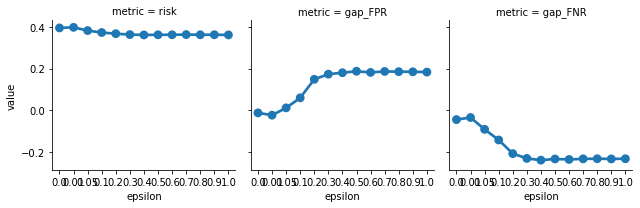

In [281]:
# Plot results: doesn't work with custom CIs. Moving to ggplot.
g = sns.FacetGrid(res, col = 'metric', col_order = ['risk', 'gap_FPR', 'gap_FNR'])
g.map(sns.pointplot, 'epsilon', 'value', ci=None)

In [351]:
# Metrics for the input predictor
res_in, res_in_arr = metrics([0, 1, 0, 1], test, A, X, R, D, Y, learner_pi,
                 learner_mu, k = 5, random_state = random_state)

In [353]:
res_in.to_csv(os.path.join(outpath, 'metrics_input.csv'), index = False)

In [138]:
# # Observable error rate for input data
# err_Y = test_target[R] != test_target[Y]
# est = err_Y.mean()
# ci_lower = est - 1.96*np.std(err_Y)/np.sqrt(len(err_Y))
# ci_upper = est + 1.96*np.std(err_Y)/np.sqrt(len(err_Y))

# print(ci_lower, est, ci_upper)

0.3287384321637972 0.35454545454545455 0.3803524769271119


In [ ]:
# Create a single table for input predictor and post-processed predictor with epsilon = 0.05

In [190]:
def comb_cols(df, name=None):
    out = df.value.apply(lambda x: '{0:.2f}'.format(x)) + \
    "  (" + df.ci_lower.apply(lambda x: '{0:.2f}'.format(x)) + ", " +\
    df.ci_upper.apply(lambda x: '{0:.2f}'.format(x)) + ")"
    
    out = out.reset_index(drop = True)#.drop(columns = 'index')
    if name:
        out.name = name
        
    return out

In [465]:
res05 = res.loc[res.epsilon == 0.05].copy()

In [466]:
res05_out = pd.DataFrame({'metric': res_in.reset_index().metric, 'est_S': comb_cols(res_in),
                  'est_S_theta': comb_cols(res05)})

In [467]:
res05_out

,metric,est_S,est_S_theta
0,FNR0,"0.30 (0.25, 0.35)","0.36 (0.31, 0.40)"
1,FNR1,"0.53 (0.46, 0.60)","0.41 (0.35, 0.46)"
2,FPR0,"0.43 (0.36, 0.49)","0.39 (0.33, 0.45)"
3,FPR1,"0.24 (0.18, 0.31)","0.42 (0.37, 0.47)"
4,gap_FNR,"-0.24 (-0.32, -0.15)","-0.05 (-0.12, 0.02)"
5,gap_FPR,"0.18 (0.09, 0.28)","-0.03 (-0.10, 0.05)"
6,risk,"0.36 (0.32, 0.41)","0.39 (0.35, 0.42)"
7,risk_change,"0.00 (0.00, 0.00)","0.03 (0.01, 0.04)"
8,prop_differ,"0.00 (0.00, 0.00)","0.09 (0.09, 0.09)"


In [447]:
# # Need to update pandas to >= 1.1 to use this approach.
# custom_dict = {'risk':0, 'risk_change':1, 'FPR0':2, 'FPR1':3, 'FNR0':4, 'FNR1':5,
#                'gap_FPR':6, 'gap_FNR':7, 'prop_differ':8}
# res05_out.sort_values(by = 'metric', key = lambda x: custom_dict[x])

In [470]:
vals

[0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [479]:
1017 + 616

1633

In [478]:
pd.crosstab(dat.race, dat.released)

released,0,1
race,,
0,1017,2158
1,616,1487


In [472]:
theta_arr

[array([0.2       , 0.85966313, 0.32227249, 1.        ]),
 array([1.80911292e-10, 8.30623628e-01, 1.56445419e-01, 1.00000000e+00]),
 array([8.27622273e-10, 9.16505324e-01, 2.31785022e-01, 9.99999999e-01]),
 array([0.09632576, 0.9761996 , 0.25441309, 1.        ]),
 array([9.06529596e-10, 9.99999995e-01, 5.44666997e-02, 9.99999998e-01]),
 array([4.51454483e-10, 9.99999999e-01, 2.07911623e-03, 9.99999997e-01]),
 array([5.98871075e-09, 9.99999999e-01, 3.67639203e-09, 9.99999992e-01]),
 array([5.70245697e-09, 9.99999999e-01, 2.01348339e-09, 9.99999995e-01]),
 array([2.60255912e-09, 1.00000000e+00, 3.22652173e-10, 9.99999996e-01]),
 array([5.18797809e-09, 9.99999999e-01, 3.21391569e-09, 9.99999989e-01]),
 array([1.78375154e-09, 1.00000000e+00, 1.54087264e-09, 9.99999994e-01]),
 array([5.70408153e-09, 9.99999999e-01, 2.74893639e-09, 9.99999985e-01]),
 array([5.33690331e-09, 1.00000000e+00, 1.08572305e-09, 9.99999992e-01])]

In [471]:
theta_arr[2]

array([8.27622273e-10, 9.16505324e-01, 2.31785022e-01, 9.99999999e-01])

In [468]:
res05_out = res05_out.iloc[[6, 7, 2, 3, 0, 1, 4, 5, 8]]

In [469]:
with open(os.path.join(outpath, 'metrics_table.csv'), 'w') as file_out:
    file_out.write(res05_out.set_index('metric').to_latex(index = True, index_names = False))

# Child welfare data

## Functions

In [12]:
def train_nuisance(train, test, A, X, R, D, Y, learner_pi, learner_mu,
                   trunc_pi=0.975):
    """Train nuisance regressions."""
    train = train.reset_index()
    test = test.reset_index()
    # pred_cols = list(itertools.chain.from_iterable([A, X, R]))
    pred_cols = [A] + X + [R]
    learner_pi.fit(train[pred_cols], train[D])
    learner_mu.fit(train.loc[train[D].eq(0), pred_cols],
                   train.loc[train[D].eq(0), Y])
    if hasattr(learner_pi, 'predict_proba'):
        pihat = pd.Series(learner_pi.predict_proba(test[pred_cols])[:, 1],
                          name='pihat').clip(upper=trunc_pi)
    else:
        pihat = pd.Series(learner_pi.predict(test[pred_cols]),
                          name='pihat').clip(upper=trunc_pi)
    if hasattr(learner_mu, 'predict_proba'):
        muhat0 = pd.Series(learner_mu.predict_proba(test[pred_cols])[:, 1],
                           name='muhat0')
    else:
        muhat0 = pd.Series(learner_mu.predict(test[pred_cols]), name='muhat0')
    phihat = pd.Series(
        (1 - test[D]) / (1 - pihat) * (test[Y] - muhat0) + muhat0,
        name='phihat')

    out = pd.concat([pihat, muhat0, phihat], axis=1)

    return out


def fair_derived(data_nuisance, data_opt, A, X, R, D, Y, learner_pi, learner_mu, epsilon_pos,
                 epsilon_neg, outcome='phihat', trunc_pi=0.975, cost1=1, cost2=1):
    """Optimization with chosen estimators for loss and fairness constraints."""
    nuis = train_nuisance(data_nuisance, data_opt, A, X, R, D, Y, learner_pi,
                          learner_mu, trunc_pi)
    data_opt = pd.concat([data_opt.reset_index(), nuis.reset_index()], axis=1)
    obj = risk_coefs2(data_opt, A=A, R=R, outcome=outcome, cost1=cost1, cost2=cost2)
    fair_pos, fair_neg = fairness_coefs(data_opt, A=A, R=R, outcome=outcome)
    theta = optimize(obj, fair_pos, fair_neg, epsilon_pos, epsilon_neg)

    out = {'theta': theta, 'risk_coefs': obj,
           'fairness_coefs_pos': fair_pos, 'fairness_coefs_neg': fair_neg}

    return out


def metrics(theta, data_nuisance, data_opt, A, X, R, D, Y, learner_pi,
            learner_mu, outcome='phihat', ci=0.95, ci_scale='logit'):
    """Compute risk and fairness metrics wrt Y0.

    Args:
      data: data over which to compute the metrics.
      outcome:
        Using phihat as the outcome yields doubly robust estimators.
        Using muhat0 as the outcome yields plugin estimators.
        Using mu0 as the outcome yields (something close to) the true metrics.
      ci: Either None, in which case no CI is computed, or a value in (0, 1).
    """
    nuis = train_nuisance(data_nuisance, data_opt, A, X, R, D, Y, learner_pi, learner_mu)
    data_opt = pd.concat([data_opt.reset_index(), nuis.reset_index()], axis=1)
    
    risk = est_risk(theta, data_opt, A=A, R=R, outcome=outcome, ci=ci, ci_scale=ci_scale)
    cFPR = est_cFPR(theta, data_opt, A=A, R=R, outcome=outcome, ci=ci, ci_scale=ci_scale)
    cFNR = est_cFNR(theta, data_opt, A=A, R=R, outcome=outcome, ci=ci, ci_scale=ci_scale)

    ## Compute P(R_theta != R), the probability the derived predictions differ
    ind_df = indicator_df(data_opt, A, R).astype(int)
    newvar = ind_df.dot([theta[0], 1 - theta[1], theta[2], 1 - theta[3]])
    diff_est = newvar.mean()           
    ## CI for P(R_theta != R)
    n = data_opt.shape[0]
    z = scipy.stats.norm.ppf((ci + 1) / 2)
    diff_sd = np.std(newvar)
    ci_lower = diff_est - z*diff_sd/np.sqrt(n)
    ci_upper = diff_est + z*diff_sd/np.sqrt(n)
    prop_differ = pd.DataFrame({'metric': 'prop_differ', 'value': diff_est,
                              'ci_lower': ci_lower, 'ci_upper': ci_upper},
                             index = [0])
        
    out = pd.concat([risk, cFPR, cFNR, prop_differ])

    return out

#########################
#### Risk functions #####
#########################

def risk_coef2(data, a, r, A='A', R='R', outcome='phihat', cost1=1, cost2=1):
    """Compute the loss coefficient for a single row, for given values
    A = a, R = r.

    Using phihat as the outcome yields a doubly robust estimator.
    Using muhat0 as the outcome yields a plugin estimator.
    Using mu0 as the outcome yields (something close to) the ``true'' loss
    coefficient.
    """
    out = (((data[A] == a) & (data[R] == r)) * (cost1 - (cost1 + cost2) * data[outcome])).mean()

    return out


def risk_coefs2(data, A='A', R='R', outcome='phihat', cost1=1, cost2=1):
    """Compute the loss coefficients.

    Using phihat as the outcome yields a doubly robust estimator.
    Using muhat0 as the outcome yields a plugin estimator.
    Using mu0 as the outcome yields (something close to) the ``true'' loss
    coefficients.
    """
    ar_list = [(0, 0), (0, 1), (1, 0), (1, 1)]
    coefs = [risk_coef2(data, a, r, A, R, outcome, cost1, cost2) for a, r in ar_list]
    out = np.array(coefs).clip(-1, 1)

    return out


## Setup

In [15]:
# Paths for saved data
datapath = '../child_welfare_analysis/'
outpath = '../child_welfare_analysis/'

In [14]:
wel_train = pd.read_csv(os.path.join(datapath, 'child_welfare_train.csv'))
wel_test = pd.read_csv(os.path.join(datapath, 'child_welfare_test.csv'))

wel_train_nuis = wel_train.loc[wel_train.partition2 == 'nuisance']
wel_train_target = wel_train.loc[wel_train.partition2 == 'target']

# wel_train = wel_train.assign(R_obs50 = (wel_train.muhat >= 0.5).astype(int),
#                             R50 = (wel_train.muhat0 >= 0.5).astype(int))
# wel_test = wel_test.assign(R_obs50 = (wel_test.muhat >= 0.5).astype(int),
#                           R50 = (wel_test.muhat0 >= 0.5).astype(int))

wel_test_nuis = wel_test.loc[wel_test.partition2 == 'nuisance']
wel_test_target = wel_test.loc[wel_test.partition2 == 'target']

In [16]:
A = 'race'
with open(os.path.join(datapath, 'predictors.txt'), 'r') as file_in:
    X = file_in.read().rstrip('\n').split('\t')
R = 'R'  # counterfactual model
# R = 'R_obs'  # observational model
# R = 'R50'
D = 'SCREEN_IN'
Y = 'REREF'

In [91]:
learner_pi_train = RandomForestClassifier(n_estimators=200, min_samples_leaf=10, max_features='sqrt')
learner_pi_test = RandomForestClassifier(n_estimators=200, min_samples_leaf=10, max_features='sqrt')
learner_mu_train = RandomForestClassifier(n_estimators=200, min_samples_leaf=10, max_features='sqrt')
learner_mu_test = RandomForestClassifier(n_estimators=200, min_samples_leaf=10, max_features='sqrt')

In [92]:
random_state = 105

In [211]:
metrics_in = metrics([0, 1, 0, 1], wel_test_nuis, wel_test_target, A, X, R, D, Y,
                    learner_pi_test, learner_mu_test)

In [212]:
# Metrics for the counterfactual model
metrics_in

,metric,value,ci_lower,ci_upper
0,risk,0.312333,0.300707,0.324200
1,risk_change,0.000000,0.000000,0.000000
0,FPR0,0.023830,0.017651,0.032102
1,FPR1,0.043346,0.034826,0.053833
2,gap_FPR,-0.019515,-0.031344,-0.007682
0,FNR0,0.954080,0.861182,0.985833
1,FNR1,0.862065,0.803065,0.905470
2,gap_FNR,0.092015,0.013031,0.169858
0,prop_differ,0.000000,0.000000,0.000000


In [97]:
# Metrics for the base rate model
metrics0 = metrics([0, 0, 0, 0], wel_test_nuis, wel_test_target, A, X, R, D, Y,
                    learner_pi_test, learner_mu_test)

,metric,value,ci_lower,ci_upper
0,risk,0.319521,0.307816,0.331457
1,risk_change,0.007722,0.000772,0.014671
0,FPR0,0.000000,0.000000,0.000000
1,FPR1,0.000000,0.000000,0.000000
2,gap_FPR,0.000000,0.000000,0.000000
0,FNR0,1.000000,1.000000,1.000000
1,FNR1,1.000000,1.000000,1.000000
2,gap_FNR,0.000000,0.000000,0.000000


In [95]:
# Using fair_derived() and metrics() functions as rewritten above.
vals = [0, 0.01, 0.05, 0.10]
out_arr = []
for val in vals:
    print("Estimating for epsilon = {}".format(val))
    out = fair_derived(wel_train_nuis, wel_train_target, A, X, R, D, Y,
                   learner_pi_train, learner_mu_train, val, val)
    out_arr.append(out)

Estimating for epsilon = 0
Estimating for epsilon = 0.01
Estimating for epsilon = 0.05
Estimating for epsilon = 0.1


In [133]:
wel_test.loc[wel_test.SCREEN_IN == 0].groupby([A, R])[['REREF']].mean()

REREF
race R          
0    0  0.305147
     1  0.519481
1    0  0.285436
     1  0.600000

In [78]:
wel_train_target.shape

(10385, 1059)

In [96]:
theta_arr = [np.round(out['theta'], 3) for out in out_arr]
theta_arr

[array([ 0.001,  1.   , -0.   ,  0.828]),
 array([0.  , 1.  , 0.  , 0.96]),
 array([0., 1., 0., 1.]),
 array([0., 1., 0., 1.])]

In [98]:
# Slightly improves the cFNR gap. Maybe.
metrics(out_arr[0]['theta'], wel_test_nuis, wel_test_target, A, X, R, D, Y,
                    learner_pi_test, learner_mu_test)

,metric,value,ci_lower,ci_upper
0,risk,0.312344,0.300882,0.324040
1,risk_change,0.001652,0.000660,0.002644
0,FPR0,0.024452,0.018408,0.032413
1,FPR1,0.035611,0.028666,0.044162
2,gap_FPR,-0.011159,-0.021506,-0.000809
0,FNR0,0.951856,0.860460,0.984470
1,FNR1,0.885167,0.835912,0.921033
2,gap_FNR,0.066689,-0.006153,0.138828


In [164]:
## Try optimizing with differential error costs -- higher cost for false negatives
val = 0.01
out_arr = []
cost_ratios = [1/3, 1/2.5, 1/2, 1/1.75, 1/1.5, 1/1.25, 1, 1.25, 1.5, 1.75, 2, 2.5, 3] 
for cc in cost_ratios:
    print("Estimating for cost ratio = {}".format(cc))
    out = fair_derived(wel_train_nuis, wel_train_target, A, X, R, D, Y,
                   learner_pi_train, learner_mu_train, val, val, cost1=1, cost2=cc)
    out_arr.append(out)

Estimating for cost ratio = 0.3333333333333333
Estimating for cost ratio = 0.4
Estimating for cost ratio = 0.5
Estimating for cost ratio = 0.5714285714285714
Estimating for cost ratio = 0.6666666666666666
Estimating for cost ratio = 0.8
Estimating for cost ratio = 1
Estimating for cost ratio = 1.25
Estimating for cost ratio = 1.5
Estimating for cost ratio = 1.75
Estimating for cost ratio = 2
Estimating for cost ratio = 2.5
Estimating for cost ratio = 3


In [165]:
theta_arr = [np.round(out['theta'], 3) for out in out_arr]
theta_arr

[array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0.   , 0.137, 0.   , 0.   ]),
 array([0.   , 1.   , 0.   , 0.726]),
 array([0.  , 1.  , 0.  , 0.94]),
 array([0.   , 1.   , 0.   , 0.934]),
 array([0.   , 1.   , 0.   , 0.939]),
 array([0.006, 1.   , 0.   , 1.   ]),
 array([0.007, 1.   , 0.   , 1.   ]),
 array([0.006, 1.   , 0.   , 1.   ]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.])]

In [168]:
type(theta_arr)

list

In [173]:
theta_arr[0].shape

(4,)

In [174]:
thetas = np.vstack(theta_arr)
# pd.concat(theta_arr, keys=cost_ratios)

In [179]:
thetas = pd.DataFrame(thetas).assign(cost_ratio = cost_ratios)

In [184]:
thetas.columns = ['theta1', 'theta2', 'theta3', 'theta4', 'cost_ratio']

In [185]:
thetas.to_csv(os.path.join('../child_welfare_analysis/', 'thetas_cost_sensitive.csv'), index = False)

In [153]:
## Try optimizing with differential error costs -- higher cost for false negatives
# vals = [0, 0.01, 0.05, 0.10, 1]
val = 0.01
out_arr = []
cost_ratios = [2**x for x in [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]]
for cc in cost_ratios:
    print("Estimating for cost ratio = {}".format(cc))
    out = fair_derived(wel_train_nuis, wel_train_target, A, X, R, D, Y,
                   learner_pi_train, learner_mu_train, val, val, cost1=1, cost2=cc)
    out_arr.append(out)

Estimating for cost ratio = 0.25
Estimating for cost ratio = 0.3535533905932738
Estimating for cost ratio = 0.5
Estimating for cost ratio = 0.7071067811865476
Estimating for cost ratio = 1
Estimating for cost ratio = 1.4142135623730951
Estimating for cost ratio = 2
Estimating for cost ratio = 2.8284271247461903
Estimating for cost ratio = 4


In [160]:
val = 0.01
out_arr = []
cost_ratios = [0.6, 0.7, 0.8, 0.9]
for cc in cost_ratios:
    print("Estimating for cost ratio = {}".format(cc))
    out = fair_derived(wel_train_nuis, wel_train_target, A, X, R, D, Y,
                   learner_pi_train, learner_mu_train, val, val, cost1=1, cost2=cc)
    print(np.round(out['theta'], 3))
    out = fair_derived(wel_train_nuis, wel_train_target, A, X, R, D, Y,
                   learner_pi_train, learner_mu_train, val, val, cost1=cc, cost2=1)
    print(np.round(out['theta'], 3))

Estimating for cost ratio = 0.6
[0.    1.    0.    0.701]
[0.007 1.    0.    1.   ]
Estimating for cost ratio = 0.7
[0.    1.    0.    0.933]
[0.007 1.    0.    1.   ]
Estimating for cost ratio = 0.8
[0.    1.    0.    0.932]
[0.    1.    0.    0.926]
Estimating for cost ratio = 0.9
[0.    1.    0.    0.933]
[0.    1.    0.    0.932]


In [154]:
theta_arr = [np.round(out['theta'], 3) for out in out_arr]
theta_arr

[array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0.   , 1.   , 0.   , 0.935]),
 array([0.   , 1.   , 0.   , 0.947]),
 array([0.007, 1.   , 0.   , 1.   ]),
 array([0.007, 1.   , 0.   , 1.   ]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.])]

In [ ]:
pd.DataFrame(theta_arr)

In [147]:
metrics(out_arr[0]['theta'], wel_test_nuis, wel_test_target, A, X, R, D, Y,
                    learner_pi_test, learner_mu_test)

,metric,value,ci_lower,ci_upper
0,risk,0.314012,0.302506,0.325751
1,risk_change,0.001576,0.000619,0.002532
0,FPR0,0.025093,0.018947,0.033166
1,FPR1,0.036561,0.029387,0.045405
2,gap_FPR,-0.011468,-0.022080,-0.000854
0,FNR0,0.952056,0.861404,0.984483
1,FNR1,0.884998,0.834854,0.921352
2,gap_FNR,0.067057,-0.005971,0.139374


In [215]:
## Get combined table for input predictor and the predictor for theta = [0, 0, 0, 0]
res_out = pd.DataFrame({'metric': metrics_in.reset_index().metric, 'est_S': comb_cols(metrics_in),
                  'est_S_0': comb_cols(metrics0)})

In [219]:
res_out

,metric,est_S,est_S_0
0,risk,"0.31 (0.30, 0.32)","0.32 (0.31, 0.33)"
1,risk_change,"0.00 (0.00, 0.00)","0.01 (0.00, 0.01)"
2,FPR0,"0.02 (0.02, 0.03)","0.00 (0.00, 0.00)"
3,FPR1,"0.04 (0.03, 0.05)","0.00 (0.00, 0.00)"
5,FNR0,"0.95 (0.86, 0.99)","1.00 (1.00, 1.00)"
6,FNR1,"0.86 (0.80, 0.91)","1.00 (1.00, 1.00)"
4,gap_FPR,"-0.02 (-0.03, -0.01)","0.00 (0.00, 0.00)"
7,gap_FNR,"0.09 (0.01, 0.17)","0.00 (0.00, 0.00)"
8,prop_differ,"0.00 (0.00, 0.00)","0.05 (0.05, 0.06)"


In [218]:
res_out = res_out.iloc[[0, 1, 2, 3, 5, 6, 4, 7, 8]]

In [222]:
with open(os.path.join(outpath, 'metrics_table.csv'), 'w') as file_out:
    file_out.write(res_out.set_index('metric').to_latex(index = True, index_names = False))